In [1]:
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader

import dataclasses
from typing import Generator
from datetime import datetime

from hydra import compose, initialize
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from dataloaders.aurora_dataload import LargeClimateDataset, aurora_batch_collate
from utils import seed_everything
from bfm_finetune.paths import REPO_FOLDER, STORAGE_DIR

from aurora import Aurora, Batch, Metadata, Aurora12hPretrained

seed_everything(42)

/home/atrantas/github/bfm-finetune/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
STORAGE_DIR: /projects/prjs1134/data/projects/biodt/storage


In [2]:
# Batch path (overriden) # bfm_cfg.evaluation.test_data
test_data_path = str(STORAGE_DIR / "monthly_batches" / "batches") # COMPLETE BATCHES
stats_path = str(
    STORAGE_DIR
    / "monthly_batches"
    / "statistics"
    / "monthly_batches_stats_splitted_channels.json"
)

bfm_config_path = REPO_FOLDER / "bfm-model/bfm_model/bfm/configs"
cwd = Path(os.getcwd())
bfm_config_path = str(bfm_config_path.relative_to(cwd))
bfm_config_path = f"../bfm-model/bfm_model/bfm/configs"
overrides = ["data.scaling.enabled=False"] # We provide unnscaled dataset, Aurora does the normalization
with initialize(version_base=None, config_path=bfm_config_path, job_name="test_app"):
    bfm_cfg = compose(config_name="train_config.yaml", overrides=overrides)
print(bfm_cfg)


test_dataset = LargeClimateDataset(
    data_dir=test_data_path,
    scaling_settings=bfm_cfg.data.scaling,
    num_species=28,
    atmos_levels=bfm_cfg.data.atmos_levels,
    model_patch_size=bfm_cfg.model.patch_size,
    max_files=3, # TODO Change this to iterate over the whole dataset!
    mode="finetune"
)
# print(test_dataset[0])
print("Reading test data from :", test_data_path)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0,
    collate_fn = aurora_batch_collate,
    drop_last=True,
    shuffle=False,
)

{'model': {'T': 2, 'surface_vars': ['t2m', 'msl', 'slt', 'z', 'u10', 'v10', 'lsm'], 'edaphic_vars': ['swvl1', 'swvl2', 'stl1', 'stl2'], 'atmos_vars': ['z', 't', 'u', 'v', 'q'], 'climate_vars': ['smlt', 'tp', 'csfr', 'avg_sdswrf', 'avg_snswrf', 'avg_snlwrf', 'avg_tprate', 'avg_sdswrfcs', 'sd', 't2m', 'd2m'], 'species_vars': ['1340361', '1340503', '1536449', '1898286', '1920506', '2430567', '2431885', '2433433', '2434779', '2435240', '2435261', '2437394', '2441454', '2473958', '2491534', '2891770', '3034825', '4408498', '5218786', '5219073', '5219173', '5219219', '5844449', '8002952', '8077224', '8894817', '8909809', '9809229'], 'vegetation_vars': ['NDVI'], 'land_vars': ['Land'], 'agriculture_vars': ['Agriculture', 'Arable', 'Cropland'], 'forest_vars': ['Forest'], 'redlist_vars': ['RLI'], 'misc_vars': ['avg_slhtf', 'avg_pevr'], 'H': 160, 'W': 280, 'num_latent_tokens': 8, 'backbone': 'swin', 'patch_size': 4, 'embed_dim': 256, 'num_heads': 16, 'head_dim': 64, 'depth': 3, 'swin_backbone_siz

In [3]:
print(f"Total length of samples {len(test_dataset)}")
batch = next(iter(test_dataloader))
for name, t in batch.atmos_vars.items():
    print(name, t.shape)


Total length of samples 3
z torch.Size([1, 2, 13, 160, 280])
t torch.Size([1, 2, 13, 160, 280])
u torch.Size([1, 2, 13, 160, 280])
v torch.Size([1, 2, 13, 160, 280])
q torch.Size([1, 2, 13, 160, 280])


In [4]:
# model = Aurora12hPretrained(use_lora=True)  # The pretrained version does not use LoRA.
# model.load_checkpoint(strict=False)
model = Aurora(use_lora=False)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")
# model.load_checkpoint()
model.eval()
model = model.to("cuda")
model

Aurora(
  (encoder): Perceiver3DEncoder(
    (surf_mlp): MLP(
      (net): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.0, inplace=False)
      )
    )
    (surf_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (pos_embed): Linear(in_features=512, out_features=512, bias=True)
    (scale_embed): Linear(in_features=512, out_features=512, bias=True)
    (lead_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (absolute_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (atmos_levels_embed): Linear(in_features=512, out_features=512, bias=True)
    (surf_token_embeds): LevelPatchEmbed(
      (weights): ParameterDict(
          (10u): Parameter containing: [torch.cuda.FloatTensor of size 512x1x2x4x4 (cuda:0)]
          (10v): Parameter containing: [torch.cuda.FloatTensor of siz

In [5]:
def _match_batch(tensor: torch.Tensor, target_len: int) -> torch.Tensor:
    """
    Ensure tensor.shape[0] == target_len. If tensor has a singleton
    batch dim (size 1) it is repeated; otherwise it is returned unchanged.
    Raises if both sides differ and neither is singleton.
    """
    B = tensor.shape[0]
    if B == target_len:
        return tensor
    if B == 1:
        reps = [target_len] + [1] * (tensor.ndim - 1)
        return tensor.repeat(*reps)
    raise ValueError(f"Cannot broadcast: tensor B={B} vs target B={target_len}")


def rollout(model: Aurora, batch: Batch, steps: int) -> Generator[Batch, None, None]:
    """Perform a roll-out to make long-term predictions.

    Args:
        model (:class:`aurora.model.aurora.Aurora`): The model to roll out.
        batch (:class:`aurora.batch.Batch`): The batch to start the roll-out from.
        steps (int): The number of roll-out steps.

    Yields:
        :class:`aurora.batch.Batch`: The prediction after every step.
    """
    # We will need to concatenate data, so ensure that everything is already of the right form.
    batch = model.batch_transform_hook(batch)  # This might modify the available variables.
    # Use an arbitary parameter of the model to derive the data type and device.
    p = next(model.parameters())
    batch = batch.type(p.dtype)
    batch = batch.crop(model.patch_size)
    batch = batch.to(p.device)

    for _ in range(steps):
        pred = model.forward(batch)

        yield pred
        batch = dataclasses.replace(
            pred,
            surf_vars={
                k: torch.cat(
                    [
                        _match_batch(batch.surf_vars[k][:, 1:], v.shape[0]),  # history (T-1) aligned
                        v                                                    # new step (T = 1)
                    ],
                    dim=1
                )
                for k, v in pred.surf_vars.items()
            },
            atmos_vars={
                k: torch.cat(
                    [
                        _match_batch(batch.atmos_vars[k][:, 1:], v.shape[0]),
                        v
                    ],
                    dim=1
                )
                for k, v in pred.atmos_vars.items()
            },
        )



In [9]:
with torch.inference_mode():
    # for batch in test_dataloader:
    batch = next(iter(test_dataloader))
    print("Input timestamp", batch.metadata.time)
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=20)]

print(len(preds))
print("Prediction timestamp", preds[-1].metadata.time)
print(preds[-1])


Input timestamp (datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 2, 1, 0, 0))
20
Prediction timestamp (datetime.datetime(2000, 1, 6, 0, 0), datetime.datetime(2000, 2, 6, 0, 0))
Batch(surf_vars={'2t': tensor([[[[274.0126, 274.1703, 274.2560,  ..., 271.0458, 271.1241, 271.5292],
          [272.6088, 272.7747, 272.8659,  ..., 270.6356, 270.8436, 271.1865],
          [272.4473, 272.9100, 273.0749,  ..., 270.9911, 271.0982, 271.2882],
          ...,
          [278.5762, 277.8864, 275.8735,  ..., 279.5868, 279.7119, 279.7324],
          [273.6451, 273.4600, 273.1350,  ..., 279.7039, 279.8372, 279.8365],
          [268.9263, 269.0964, 270.8102,  ..., 279.7112, 279.8187, 279.8600]]],


        [[[273.6898, 273.8419, 273.9242,  ..., 271.0377, 271.0942, 271.4695],
          [272.2728, 272.4011, 272.4733,  ..., 270.5761, 270.7695, 271.0905],
          [272.0825, 272.5017, 272.6447,  ..., 270.8578, 270.9699, 271.1552],
          ...,
          [278.5468, 277.7183, 275.4593,  ..., 279.

In [10]:
target = preds[-1]
target.surf_vars["2t"].shape # t2m # THIS ONE WE NEED ! The temperature

torch.Size([2, 1, 160, 280])

In [11]:
PRED_ROOT = Path("predictions")

def save_last_prediction(pred: Batch):
    """Save *one* Batch object to <PRED_ROOT>/<YYYY-MM>.pt"""
    month_key = pred.metadata.time[-1].strftime("%Y-%m")  # take last timestep in tuple
    path = PRED_ROOT / f"{month_key}.pt"
    path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(pred, path)
    print(f"Saved {path}")

def load_prediction(month_key: str) -> Batch:
    """Load a saved Batch, e.g. month_key='2000-01'."""
    path = PRED_ROOT / f"{month_key}.pt"
    if not path.exists():
        raise FileNotFoundError(path)
    return torch.load(path, map_location="cpu", weights_only=False)

    

In [12]:
model.eval().to("cuda")

with torch.inference_mode():
    for batch in test_dataloader:
        print("Input timestamp", batch.metadata.time)

        # run one-month forecast (2 x 6-hour steps x ~30 days = 120 steps)  
        preds = [p.to("cpu") for p in rollout(model, batch, steps=1)]
        last_pred = preds[-1]

        save_last_prediction(last_pred)

Input timestamp (datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 2, 1, 0, 0))
Saved predictions/2000-02.pt
Input timestamp (datetime.datetime(2000, 2, 1, 0, 0), datetime.datetime(2000, 3, 1, 0, 0))
Saved predictions/2000-03.pt
Input timestamp (datetime.datetime(2000, 3, 1, 0, 0), datetime.datetime(2000, 4, 1, 0, 0))
Saved predictions/2000-04.pt


forecast valid time: (datetime.datetime(2000, 2, 1, 6, 0), datetime.datetime(2000, 3, 1, 6, 0))
Temp shape torch.Size([2, 1, 160, 280])


Text(0.5, 1.0, '2-m temp')

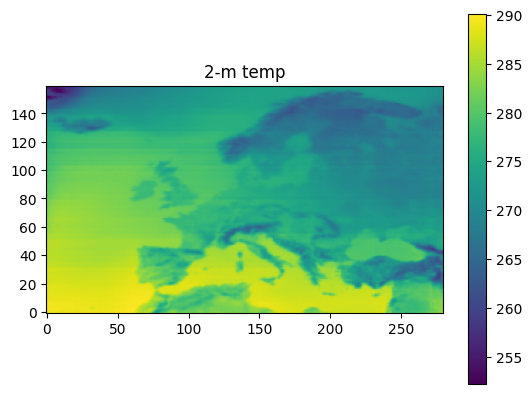

In [13]:
pred = load_prediction("2000-03") # load March forecast
print("forecast valid time:", pred.metadata.time)

# quick look at surface temperature field of the second time step
t2 = pred.surf_vars["2t"]
print("Temp shape", t2.shape)
plt.imshow(t2[0][0], origin="lower"); plt.colorbar(); plt.title("2-m temp")